In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/experiments/alifbanktest/credit_train.csv', sep=';', encoding="cp1251", index_col='client_id')
blindSet = pd.read_csv('/content/drive/MyDrive/experiments/alifbanktest/credit_test.csv', sep=';', encoding="cp1251", index_col='client_id')

In [4]:
df.head(5)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
client_id,,,,,,,,,,,,,,
1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [5]:
df['score_shk'].replace(',', '.', regex=True, inplace=True)
df['credit_sum'].replace(',', '.', regex=True, inplace=True)
df = df.astype({'credit_sum': float, 'score_shk': float})

# 1. EDA

In [14]:
df.drop_duplicates(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169601 entries, 1 to 170746
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                169601 non-null  object 
 1   age                   169601 non-null  int64  
 2   marital_status        169601 non-null  object 
 3   job_position          169601 non-null  object 
 4   credit_sum            169601 non-null  float64
 5   credit_month          169601 non-null  int64  
 6   tariff_id             169601 non-null  float64
 7   score_shk             169601 non-null  float64
 8   education             169601 non-null  object 
 9   living_region         169412 non-null  object 
 10  monthly_income        169600 non-null  float64
 11  credit_count          160411 non-null  float64
 12  overdue_credit_count  160411 non-null  float64
 13  open_account_flg      169601 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 19.

In [13]:
#Кол-во None значений в датасете
df.isnull().sum()

gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region            189
monthly_income             1
credit_count            9190
overdue_credit_count    9190
open_account_flg           0
dtype: int64

In [15]:
df.dropna(inplace=True)

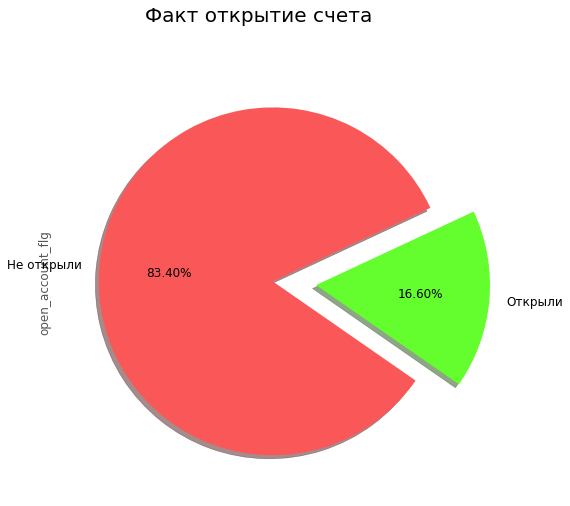

In [16]:
f, ax = plt.subplots(1,1, figsize=(16,8))

colors = ["#FA5858", "#64FE2E"]
labels ="Не открыли", "Открыли"

plt.suptitle('Факт открытие счета', fontsize=20)

df["open_account_flg"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax, shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)


plt.show()

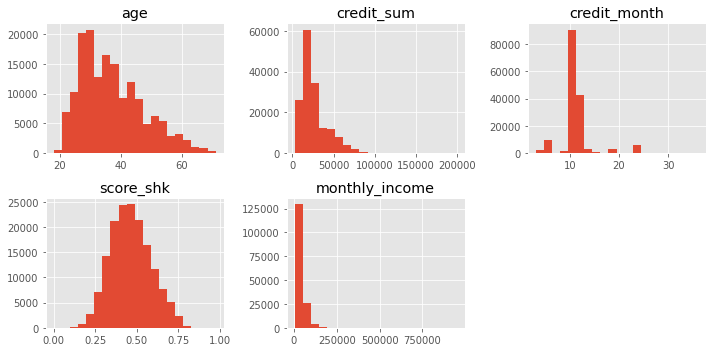

In [17]:
numerical = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income']
df[numerical].hist(bins=20, layout=(2, 3), figsize=(10,5))

plt.tight_layout()
plt.show()

In [18]:
df.nunique()

gender                      2
age                        54
marital_status              5
job_position               17
credit_sum              41440
credit_month               31
tariff_id                  32
score_shk               15898
education                   5
living_region             298
monthly_income           1544
credit_count               21
overdue_credit_count        4
open_account_flg            2
dtype: int64

In [20]:
# Всего 160238 человек в датасете
df.shape

(160238, 14)

In [21]:
df.mean(numeric_only=True)

age                        37.047436
credit_sum              25915.275960
credit_month               10.994421
tariff_id                   1.320653
score_shk                   0.464947
monthly_income          40402.294063
credit_count                2.107546
overdue_credit_count        0.046075
open_account_flg            0.166047
dtype: float64

### Describe summary
1. Средний возраст клиентов в датасете 37 лет
2. Средняя сумма кредита 25 915 рублей
2. Средний срок кредита 11 месяцев (краткосрочные)
3. Средний доход клиентов 40 тысю рублей
5. Средний score 0.464
6. Средний клиент уже имеет 2 кредита

### Gender
<i> Распределение <b>gender</b> в датасете

In [22]:
#Сколько мужчин и женщин
df.gender.value_counts()

F    83520
M    76718
Name: gender, dtype: int64

In [23]:
#Их процентное соотношение
df['gender'].value_counts(normalize=True).mul(100)

F    52.122468
M    47.877532
Name: gender, dtype: float64

In [24]:
def plotDistribution(column, title):
  norm_target = (
      df
      [column]
      .value_counts(normalize=True)
      .mul(100)
      .rename('percent')
      .reset_index()
  )

  plt.figure(figsize=(8, 7))

  ax = sns.barplot(
      x='index',
      y='percent',
      data=norm_target
  )

  for p in ax.patches:
      percentage = '{:.1f}%'.format(p.get_height())
      ax.annotate(
          percentage,  
          (p.get_x() + p.get_width() / 2., p.get_height()), 
          ha='center', 
          va='center',
          xytext=(0, 10),
          textcoords='offset points', 
          fontsize=14
      )

  plt.title(f'{title} distribution', fontsize=16)
  plt.xlabel(f'{title.lower()}', fontsize=12)
  plt.ylabel('Percentage', fontsize=12)

  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12);

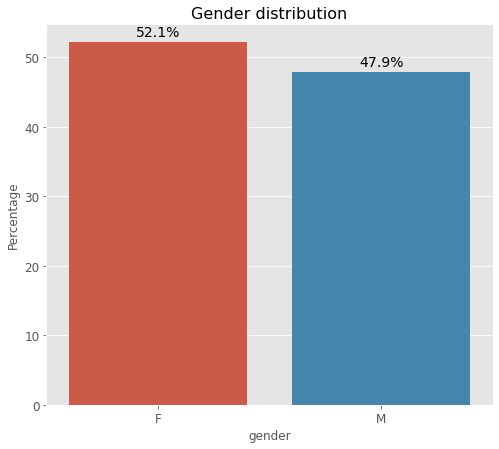

In [25]:
plotDistribution('gender', 'Gender')

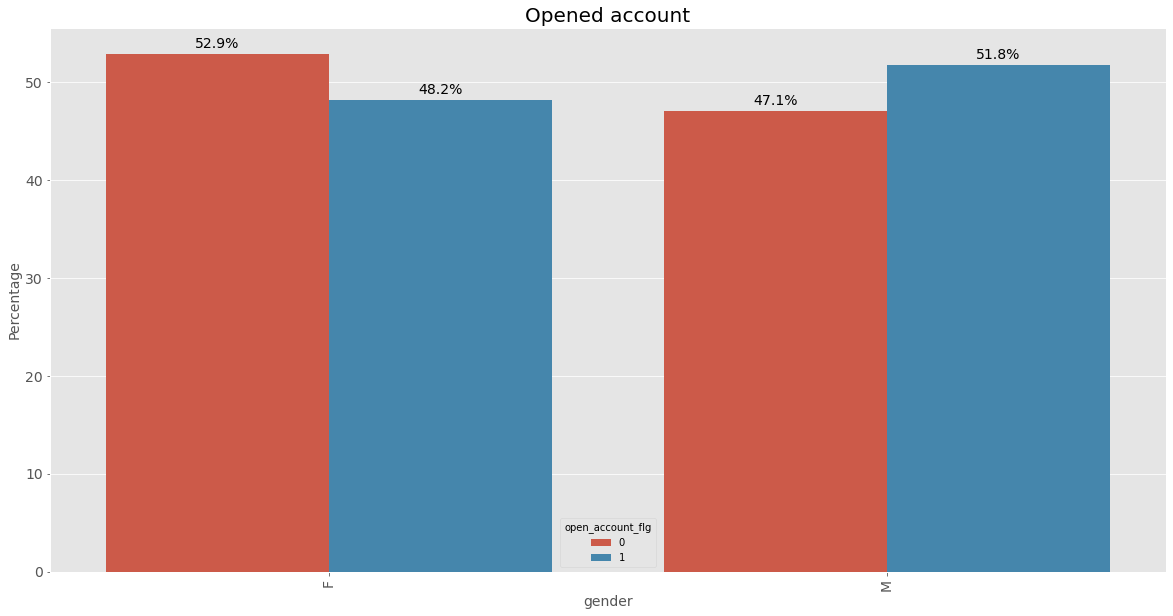

In [26]:
# Факт открытие счета по гендерному распределению
plt.figure(figsize=(20, 10))

educ_def = (df.groupby(['open_account_flg'])['gender']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('gender'))

ax = sns.barplot(x="gender", y="percentage", hue="open_account_flg", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)

plt.title('Opened account', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('gender', fontsize=14)
plt.xticks(rotation=90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

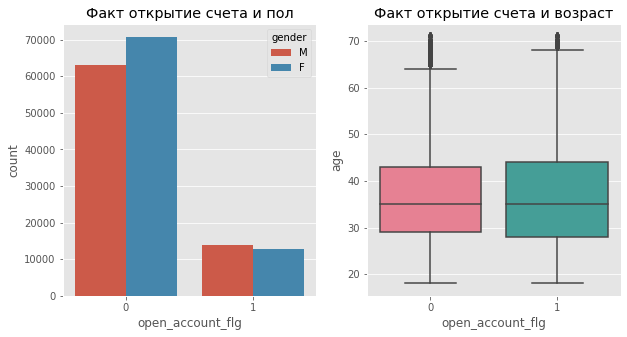

In [27]:
#Факт открт и пол
#Классы и возраст
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.countplot(x="open_account_flg", hue="gender", data=df, ax=ax)
plt.title('Факт открытие счета и пол')

ax = plt.subplot(1,2,2)
sns.boxplot(x="open_account_flg", y="age", palette='husl', data=df, ax=ax);
plt.title('Факт открытие счета и возраст')
plt.show()

In [28]:
# Распределение клиентов по гендеру и по фактору открытие счета
pd.crosstab(df["open_account_flg"], df.gender)

gender,F,M
open_account_flg,,
0,70704,62927
1,12816,13791


#### Summary gender
* Всего клиентов: 160 238
* Мужины: 76718
* Женщины: 83520

* % распределение:
* Мужчины: 47.8%
* Женщины: 52%

* Мужчины больше открывают счет, чем женщины (кол-во женщин, которые не открыли счет выше чем мужчин) 
* Средний возраст клиентов, которые не открыли счет выше, чем у тех кто открыл счет


### Age

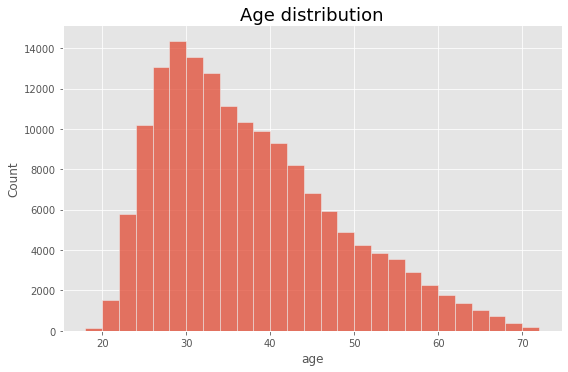

In [29]:
sns.displot(x='age', data=df, binwidth=2, height=5, aspect=1.6);
plt.title('Age distribution', fontsize=18);

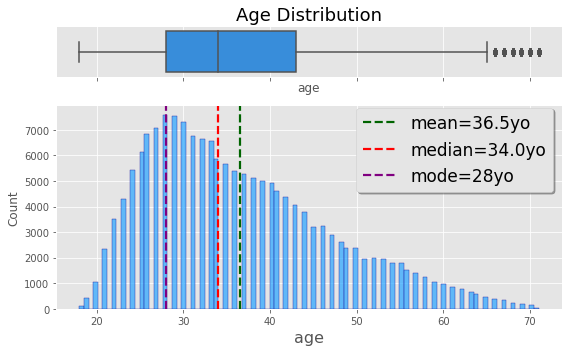

In [ ]:
num_plot(df, 'age', 'Age Distribution', 'yo')

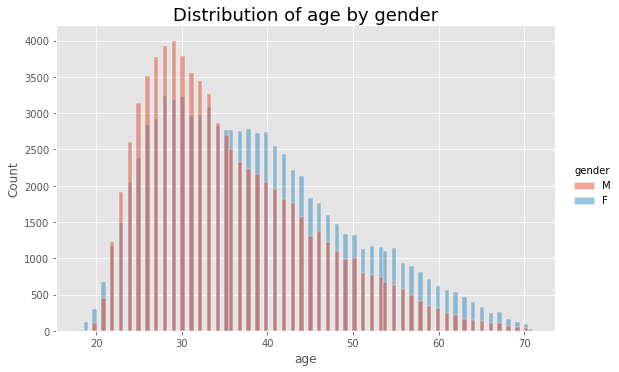

In [30]:
sns.displot(df, x="age", hue="gender", height=5, aspect=1.6)
plt.title('Distribution of age by gender', fontsize=18);

<b>Summary: </b>В возрасте от 21-35 количество молодых людей больше чем женщин, после 35 наоборот

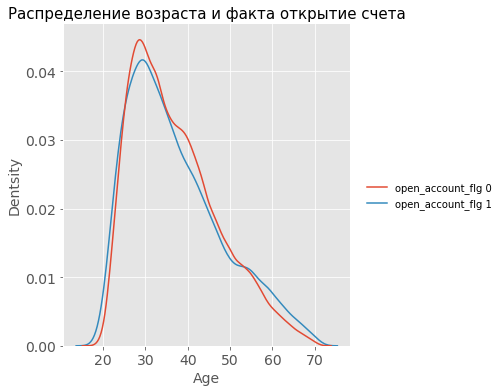

In [31]:
sns.displot(
    {
        "open_account_flg 0": df[df.open_account_flg == 0].age,
        "open_account_flg 1": df[df.open_account_flg == 1].age
    },
    kind="kde",
    common_norm=False
)

plt.title('Распределение возраста и факта открытие счета', fontsize=15)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [32]:
# Процентное распредление молодых клиентов в возрасте от 20 дo 35
age_list = []
def age_distribution(df):
    for age in df['age']:
        if 20 <= age <= 35:
            age_list.append(age)

    return (len(age_list) / df.age.count())*100

print(f'Процент клиентов от 20-35: {round(age_distribution(df),2)}%')

Процент клиентов от 20-35: 51.42%


In [33]:
# Максимальный и минимальный возраст клиентов
print(f'Max: {df.age.max()}', f'\nMin: {df.age.min()}')

Max: 71 
Min: 18


#### Age summary
* 51.42% клиентов в возрасте от 20-35 лет
* Самый молодому 18 самому старшему 71 лет
* Различие между женщинами и мужчинами в минимальных и максимальных значениях нет. Есть различие в среднем возрасте на 2 года

# Marital status

In [34]:
# Количество клиентов по семейному положению
df['marital_status'].value_counts(dropna = False)

MAR    90553
UNM    45906
DIV    16429
CIV     3947
WID     3403
Name: marital_status, dtype: int64

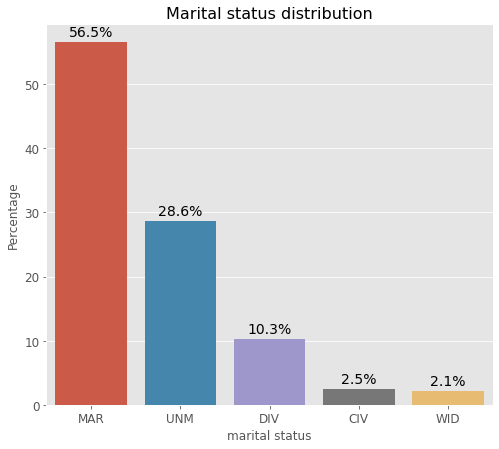

In [35]:
#Процентное распределение клиентов по семейному положению
plotDistribution('marital_status', 'Marital status')

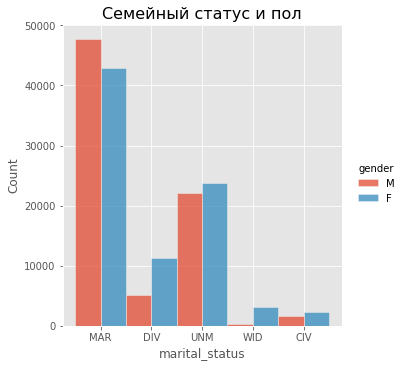

In [36]:
sns.displot(df, x="marital_status", hue="gender", multiple="dodge")
plt.title('Семейный статус и пол', fontsize=16)
plt.show()

#### <b>Summary</b>: 
* Семейное положение
 * 56.5% процентов клиентов женаты/замужем
 * 28.6% не женаты
 * 10.3% разведены
 * 2.5% вдовы
* Во всех категориях кроме женатый, кол-во женщин больше чем мужчин

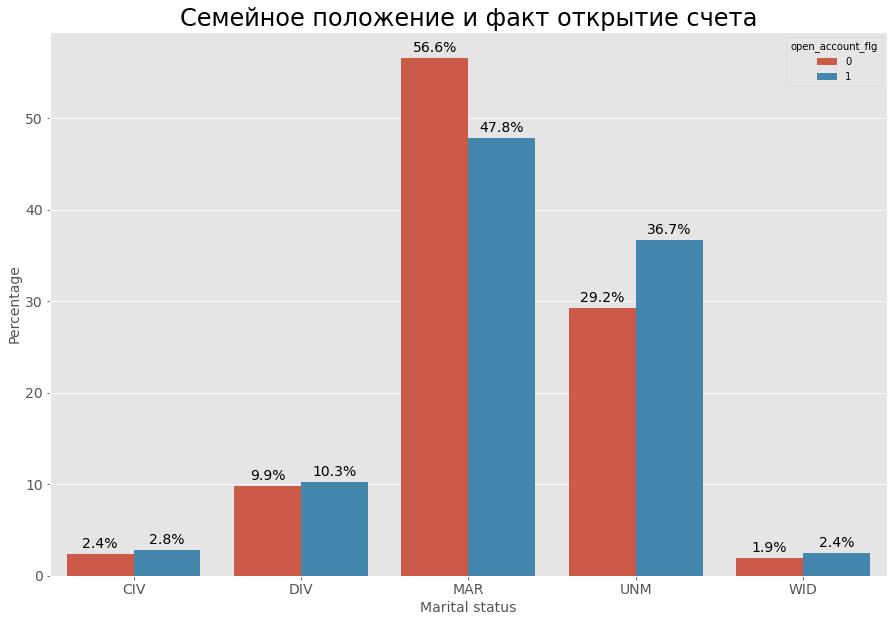

In [ ]:
plt.figure(figsize=(15, 10))

educ_def = (df.groupby(['open_account_flg'])['marital_status']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('marital_status'))

ax = sns.barplot(x="marital_status", y="percentage", hue="open_account_flg", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)

plt.title('Семейное положение и факт открытие счета', fontsize=24)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Marital status', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: Если посмотреть на процентное соотношения фактического открытия счета, то семейные люди открывали счет больше, чем остальные. Но по факту открытия счета, чем не открытие, то не семейные люди больше открывали счет.

# Education

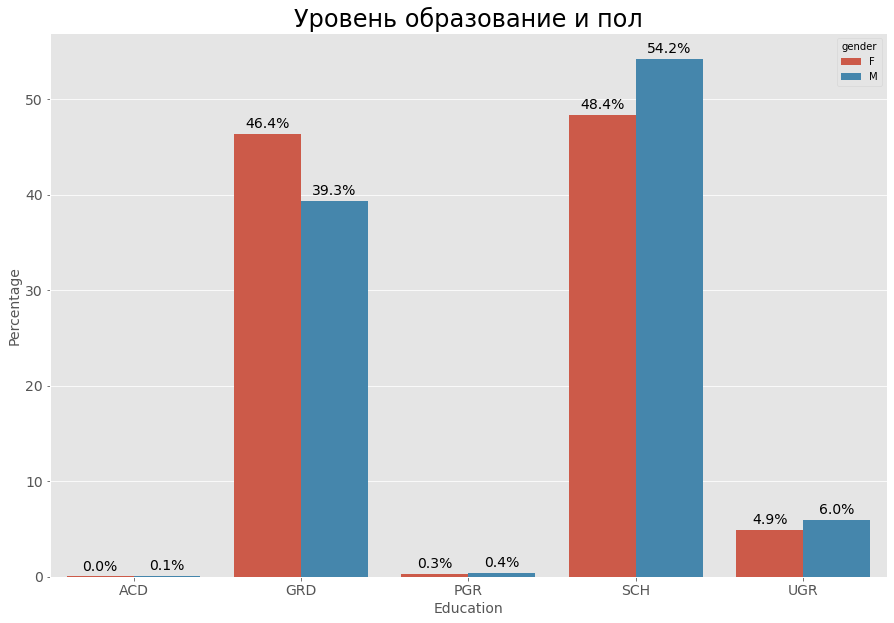

In [37]:
plt.figure(figsize=(15, 10))

educ_def = (df.groupby(['gender'])['education']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('education'))

ax = sns.barplot(x="education", y="percentage", hue="gender", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)

plt.title('Уровень образование и пол', fontsize=24)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: 
* Кол-во женщин с вышсем образованием выше, чем мужчин. 

In [38]:
# Данная функция удаляет выбросы
def remove_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

w_outliers_data = remove_outliers(df, 'monthly_income')

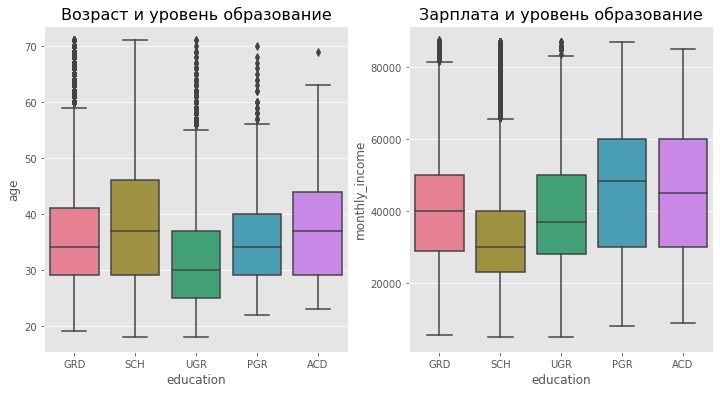

In [39]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
plt.title('Возраст и уровень образование', fontsize=16)
sns.boxplot(x="education", y="age", palette='husl', data=df, ax=ax)
ax = plt.subplot(1,2,2)
sns.boxplot(x="education", y="monthly_income", palette='husl', data=w_outliers_data, ax=ax)
plt.title('Зарплата и уровень образование', fontsize=16)
plt.show()

#### <b>Summary</b>: 
* Средний возраст людей с уровнем образование бакалавр, ниже чем у остальных.
* Чем ниже ступень образование тем, тем меньше средняя зарплата. Средняя зарплата у людей со школьным образованием ниже чем у всех остальных.

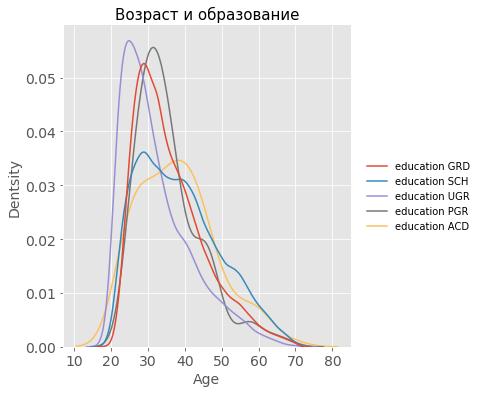

In [40]:
sns.displot(
    {
        "education GRD": df[df.education == 'GRD'].age,
        "education SCH": df[df.education == 'SCH'].age,
        "education UGR": df[df.education == 'UGR'].age,
        "education PGR": df[df.education == 'PGR'].age,
        "education ACD": df[df.education == 'ACD'].age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Возраст и образование', fontsize=15)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: 
* Чаще всего молодые люди от 20-30 имеют уровень образование бакалавр

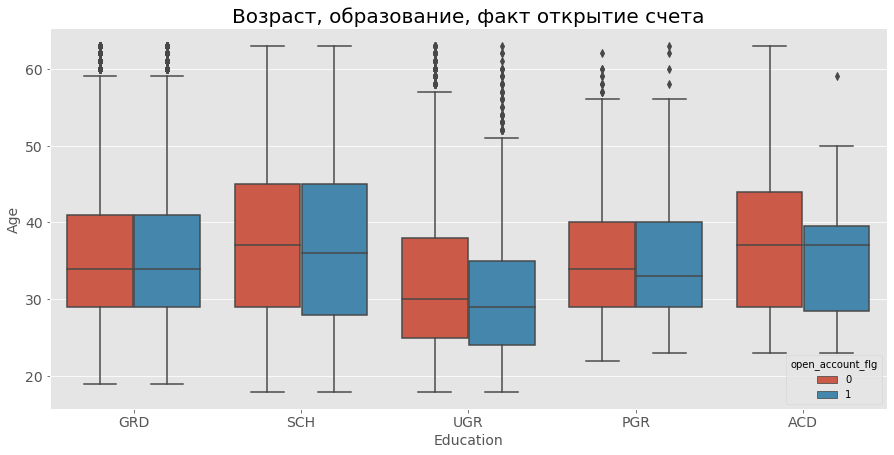

In [41]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', hue='open_account_flg', data=remove_outliers(df, 'age'))

plt.title('Возраст, образование, факт открытие счета', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: 
* Средний возраст клиентов уровень образование которых UGR и которые открывают счет ниже чем у остальных. 

#Job position

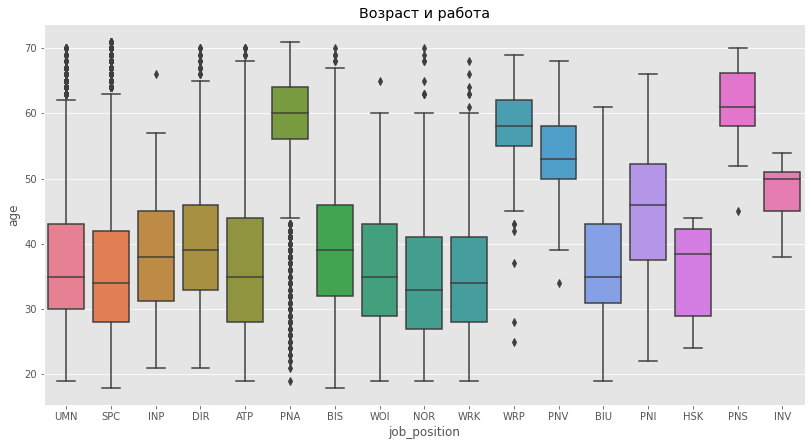

In [42]:
plt.figure(figsize=(30,7))
ax = plt.subplot(1,2,1)
sns.boxplot(x="job_position", y="age", palette='husl', data=df, ax=ax)
plt.title('Возраст и работа')
plt.show()

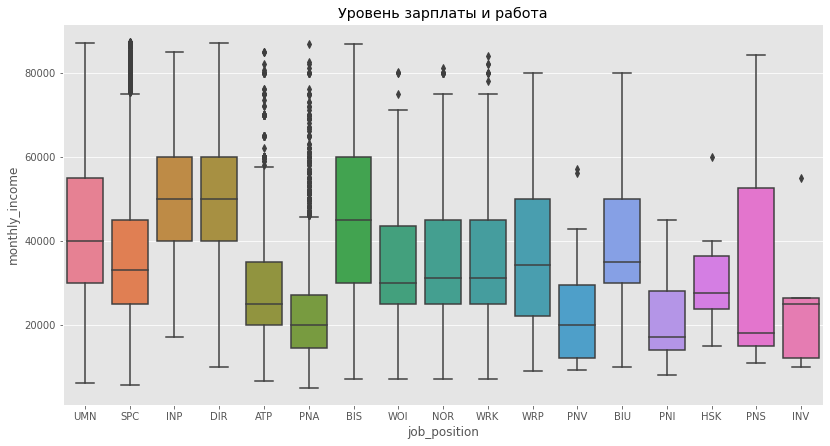

In [43]:
plt.figure(figsize=(30,7))
ax = plt.subplot(1,2,1)
sns.boxplot(x="job_position", y="monthly_income", palette='husl', data=w_outliers_data, ax=ax)
plt.title('Уровень зарплаты и работа')
plt.show()

#### <b>Summary</b>: 
* Средний возраст безработных молодых людей 35 лет

In [44]:
# Регионы в которых больше всего открывали счета
opened_region = pd.crosstab(df["living_region"], df.open_account_flg)
opened_region[opened_region[1]>500]

open_account_flg,0,1
living_region,,
КРАСНОДАРСКИЙ КРАЙ,5598,1299
КРАСНОЯРСКИЙ КРАЙ,2236,506
МОСКВА,3937,1115
МОСКВА Г,2815,525
ОБЛ ИРКУТСКАЯ,3038,800
ОБЛ КЕМЕРОВСКАЯ,2147,532
ОБЛ МОСКОВСКАЯ,9399,1874
ОБЛ НИЖЕГОРОДСКАЯ,2773,555
РЕСП БАШКОРТОСТАН,3958,652


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text major ticklabel objects>)

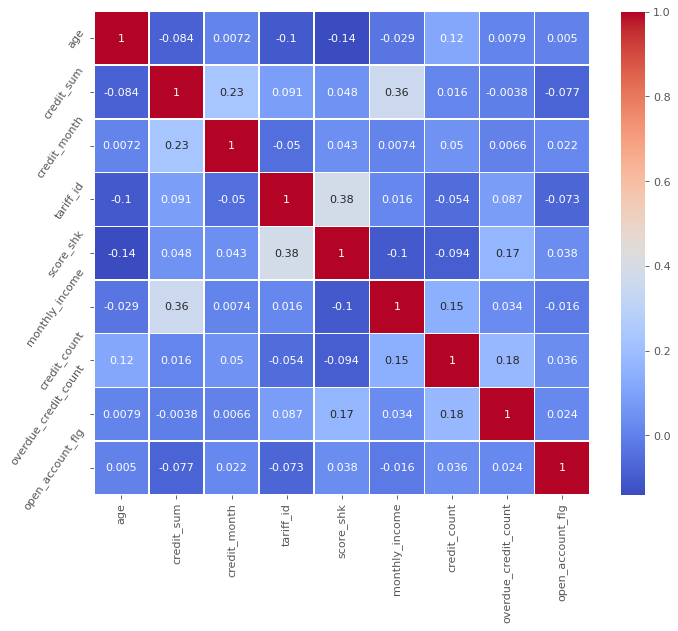

In [45]:
plt.figure(figsize=(10,8),dpi=80)
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,linewidth=0.5)
plt.yticks(rotation=55)